In [1]:
!pip install mplfinance
from market_imbalance import MarketImbalance


def find_imbalances_after_fall(historical_candles):
    imbalances_after_fall = []
    for index in range(len(historical_candles)):
        if index == 0 or index == len(historical_candles) - 1:
            continue
        prev_candle = historical_candles[index - 1]
        current_candle = historical_candles[index]
        next_candle = historical_candles[index + 1]
        if prev_candle.low_price > next_candle.high_price:
            delta_to_be_filled_in = prev_candle.low_price - next_candle.high_price
            
            imbalance = MarketImbalance(
                imbalance_type="imbalance_after_fall",
                timestamp=current_candle.timestamp,
                open_price=next_candle.high_price,
                close_price=prev_candle.low_price,
                delta_to_be_filled_in=delta_to_be_filled_in,
                is_full_filled=False,
                was_fullfilled_at=None,
                time_to_be_fullfilled=None,
                is_partially_filled=False,
                remaining_delta_open_price=None,
                remaining_delta_to_be_filled_in=None,
                candles_of_identification=(prev_candle, current_candle, next_candle),
                candles_of_fullfilling=None,
                candles_of_partfilling=None
            )
            imbalances_after_fall.append(imbalance)
    return imbalances_after_fall

def find_imbalances_after_rise(historical_candles):
    imbalances_after_rise = []
    for index in range(len(historical_candles)):
        if index == 0 or index == len(historical_candles) - 1:
            continue
        prev_candle = historical_candles[index - 1]
        current_candle = historical_candles[index]
        next_candle = historical_candles[index + 1]
        if prev_candle.high_price < next_candle.low_price:
            delta_to_be_filled_in = next_candle.low_price - prev_candle.high_price
            
            imbalance = MarketImbalance(
                imbalance_type="imbalance_after_rise",
                timestamp=current_candle.timestamp,
                open_price=next_candle.low_price,
                close_price=prev_candle.high_price,
                delta_to_be_filled_in=delta_to_be_filled_in,
                is_full_filled=False,
                was_fullfilled_at=None,
                time_to_be_fullfilled=None,
                is_partially_filled=False,
                remaining_delta_open_price=None,
                remaining_delta_to_be_filled_in=None,
                candles_of_identification=(prev_candle, current_candle, next_candle),
                candles_of_fullfilling=None,
                candles_of_partfilling=None
            )
            imbalances_after_rise.append(imbalance)
    return imbalances_after_rise

def get_unfilled_imbalances(imbalances):
    unfilled_imbalances = [imbalance for imbalance in imbalances if not imbalance.is_full_filled]
    return unfilled_imbalances


In [2]:
# !pip install python-binance
import os
from interact_with_binance import fetch_ohlcv, fetch_ohlcv_as_df
from market_candles import MarketCandle
from binance.client import Client
from convert_ts_to_datetime import convert_ts_to_datetime


api_key = os.environ.get('BINANCE_API_KEY')
api_secret = os.environ.get('BINANCE_API_SECRET')
client = Client(api_key, api_secret)

# Récupère les données de marché en *temps différé* sur Binance
interval_value = Client.KLINE_INTERVAL_1HOUR
from_date = "3 avril 2024"

historical_candles = fetch_ohlcv(client, symbol = "BTCUSDT", interval=interval_value, from_date=from_date) #"1 Jan, 2015"
historical_candles_df = fetch_ohlcv_as_df(client, symbol = "BTCUSDT", interval=interval_value, from_date=from_date) #"1 Jan, 2015"
historical_candles_df[0:5]

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
timestamp,,,,,,,,,,,
2024-04-03 00:00:00,65463.99,65610.00,64493.07,65387.99,4115.32826,2024-04-03 00:59:59.999,2.680072e+08,139236,1875.25183,1.221588e+08,0.0
2024-04-03 01:00:00,65388.00,65930.51,65090.00,65792.43,2368.51560,2024-04-03 01:59:59.999,1.550170e+08,104364,1151.14422,7.535924e+07,0.0
2024-04-03 02:00:00,65792.42,66052.00,65683.74,65906.49,1601.22687,2024-04-03 02:59:59.999,1.054656e+08,84772,840.19974,5.534558e+07,0.0
2024-04-03 03:00:00,65906.49,66288.88,65764.00,66225.79,1266.05890,2024-04-03 03:59:59.999,8.354729e+07,69226,743.92623,4.909171e+07,0.0
2024-04-03 04:00:00,66225.79,66478.59,66120.00,66320.41,1350.05763,2024-04-03 04:59:59.999,8.949617e+07,68930,747.83740,4.957627e+07,0.0


In [3]:
# Récupère les imbalances à partir des infos de marché
imbalances_after_fall = find_imbalances_after_fall(historical_candles)
imbalances_after_rise = find_imbalances_after_rise(historical_candles)

# Identifie uniquement les imbalances qu'il reste à combler
unfilled_imbalances_after_fall = get_unfilled_imbalances(imbalances_after_fall)
unfilled_imbalances_after_rise = get_unfilled_imbalances(imbalances_after_rise)

#for imb in unfilled_imbalances_after_rise[-10:] : 
    #print('fullfilled =',imb.is_full_filled, ',imbalance that started on', convert_ts_to_datetime(imb.timestamp), 'at an open price =', imb.open_price, 'at on close_price =', imb.close_price, 'with a delta =', round(imb.delta_to_be_filled_in, 2))

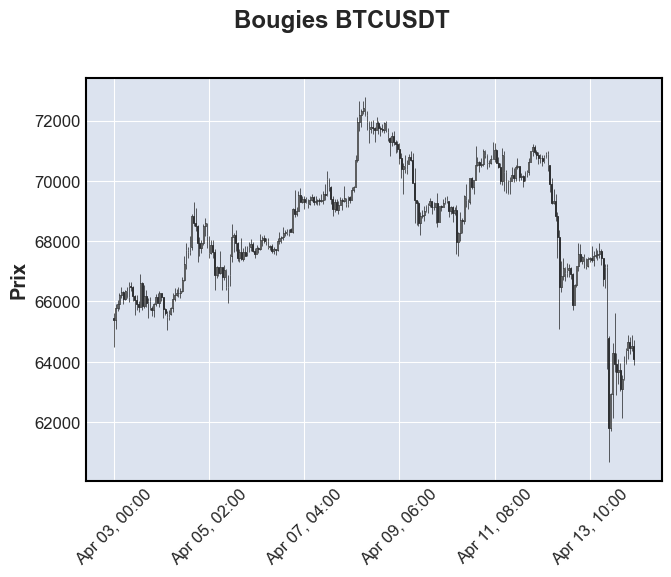

In [4]:
import mplfinance as mpf
import pandas as pd

# Tracer les bougies avec mplfinance
mpf.plot(historical_candles_df, type='candle', title='Bougies BTCUSDT', ylabel='Prix')



In [5]:
import plotly.graph_objects as go

# Tracer les bougies avec Plotly
fig = go.Figure(data=[go.Candlestick(x=historical_candles_df.index,
                open=historical_candles_df['open'],
                high=historical_candles_df['high'],
                low=historical_candles_df['low'],
                close=historical_candles_df['close'])])
fig.update_layout(title='Bougies BTCUSDT',
                  xaxis_title='Date',
                  yaxis_title='Prix',
                  height=1000)  # Ajustez la hauteur ici selon vos besoins
fig.show()

Loading BokehJS ...

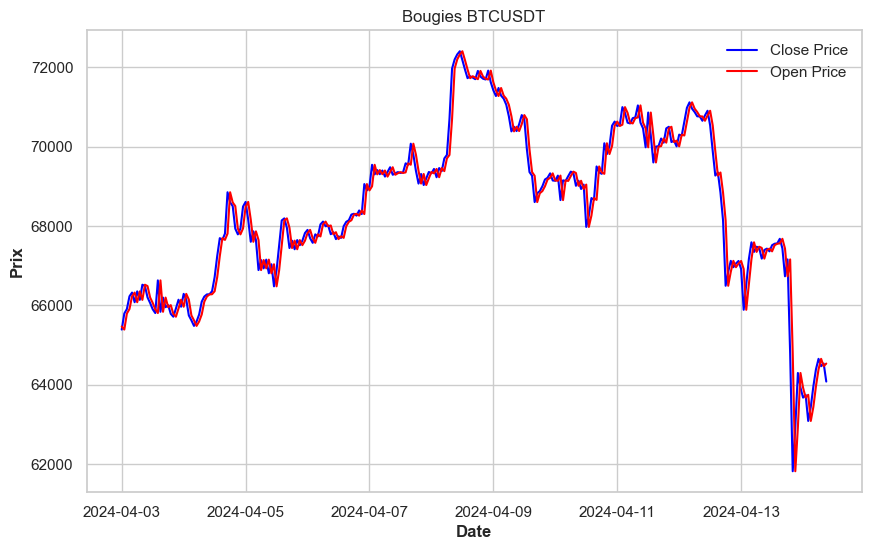

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définir le style seaborn
sns.set(style="whitegrid")

# Tracer les bougies avec Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(historical_candles_df.index, historical_candles_df['close'], color='blue', label='Close Price')
plt.plot(historical_candles_df.index, historical_candles_df['open'], color='red', label='Open Price')

# Ajouter des détails au graphique
plt.title('Bougies BTCUSDT')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()

# Afficher le graphique
plt.show()


In [8]:
'''from market_imbalance import find_imbalances_after_fall, get_fullfilled_imbalances_after_fall, find_imbalances_after_rise, get_fullfilled_imbalances_after_rise

imbalances_after_fall = find_imbalances_after_fall(df)
fullfilled_imbalances_after_fall = get_fullfilled_imbalances_after_fall(imbalances_after_fall, df)

imbalances_after_rise = find_imbalances_after_rise(df)
fullfilled_imbalances_after_rise = get_fullfilled_imbalances_after_rise(imbalances_after_rise, df)

# Percentage of gap filled after fall
percentage_filled_after_fall = (len(fullfilled_imbalances_after_fall) / len(find_imbalances_after_fall)) * 100
print(f'% of filled gap after fall = {percentage_filled_after_fall} with {len(fullfilled_imbalances_after_fall)} fullfilled imbalances on {len(imbalances_after_fall)} in total')

# Percentage of gap filled after rise
percentage_filled_after_rise = (len(fullfilled_imbalances_after_rise) / len(find_imbalances_after_rise)) * 100
print(f'% of filled gap after rise = {percentage_filled_after_rise} with {len(fullfilled_imbalances_after_rise)} fullfilled imbalances on {len(imbalances_after_rise)} in total')
'''

"from market_imbalance import find_imbalances_after_fall, get_fullfilled_imbalances_after_fall, find_imbalances_after_rise, get_fullfilled_imbalances_after_rise\n\nimbalances_after_fall = find_imbalances_after_fall(df)\nfullfilled_imbalances_after_fall = get_fullfilled_imbalances_after_fall(imbalances_after_fall, df)\n\nimbalances_after_rise = find_imbalances_after_rise(df)\nfullfilled_imbalances_after_rise = get_fullfilled_imbalances_after_rise(imbalances_after_rise, df)\n\n# Percentage of gap filled after fall\npercentage_filled_after_fall = (len(fullfilled_imbalances_after_fall) / len(find_imbalances_after_fall)) * 100\nprint(f'% of filled gap after fall = {percentage_filled_after_fall} with {len(fullfilled_imbalances_after_fall)} fullfilled imbalances on {len(imbalances_after_fall)} in total')\n\n# Percentage of gap filled after rise\npercentage_filled_after_rise = (len(fullfilled_imbalances_after_rise) / len(find_imbalances_after_rise)) * 100\nprint(f'% of filled gap after rise = 